In [1]:
# COMP4448
# Data Science Tools 2
# Final Project
# Sam Roberts-Baca & Thomas Tellner
# Fall Quarter 2021

import pandas as pd

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

import nltk


## Research Questions:
1)	How well doea Naive Bayes algorithm predict music release genre from its lyrical content?

2)	How well does a KNN-Classifier Algorithm predict music release genre from its lyrical content?

3)	How do the Naïve Bayes and KNN-Classifier algorithms compare to one another in terms of predicting music release genres from lyrics?

In [2]:
# read in data
bandcamp_df = pd.read_csv('./scrape_data_Aug-20-2021_013514.csv',encoding='utf-8')
bandcamp_df.head()

,Unnamed: 0,Release Genre,Release Sub-Genre,Search Format,Search Week,Search Category,Release URL,Scrape Date,Release Title,Artist Name,Artist Location,Release Date,Tags,Track Info,All Lyrics,Number of Tracks
0,0,all,all,all,this week,top,https://parquetcourts.bandcamp.com/album/sympa...,2021-08-19,Sympathy for Life,Parquet Courts,"Brooklyn, New York",2021-10-22,"['alternative', 'indie rock', 'New York']","[{'Track Title': 'Walking at a Downtown Pace',...",NaN,11
1,1,all,all,all,this week,top,https://portrayalofguilt.bandcamp.com/album/po...,2021-08-19,portrayal of guilt / Chat Pile Split,portrayal of guilt,"Austin, Texas",2021-08-17,"['punk', 'black metal', 'hardcore', 'metal', '...","[{'Track Title': 'Touched by an Angel', 'Track...","\nMy mind, tortured and depraved.\nDissolving....",2
2,2,all,all,all,this week,top,https://johncarpentermusic.bandcamp.com/album/...,2021-08-19,Halloween Kills OST,John Carpenter,"Los Angeles, California",2021-10-15,"['alternative', 'electronic', 'new age', 'prog...","[{'Track Title': 'Logos Kill', 'Track Lyrics':...",NaN,20
3,3,all,all,all,this week,top,https://tossportal.bandcamp.com/album/still-sl...,2021-08-19,still slipping vol. 1,Joy Orbison,"London, UK",2021-08-13,"['electronic', 'London']","[{'Track Title': 'w/ dad & frankie', 'Track Ly...",NaN,14
4,4,all,all,all,this week,top,https://grouchnz.bandcamp.com/album/rare-speci...,2021-08-19,Rare Specimens,Grouch / Grouch In Dub,New Zealand,2021-08-16,"['dub', 'electronic', 'grouch', 'psychedelic',...","[{'Track Title': 'Right Lymph Node', 'Track Ly...",NaN,8


# Part 1: Data Processing

In [3]:
# only use release genre, search category, lyrics columns
bandcamp_df = bandcamp_df[['Release Genre','Release Sub-Genre','Search Category','All Lyrics']]

# remove albums with 'All' genre selected
bandcamp_df = bandcamp_df.loc[bandcamp_df['Release Genre'] != 'all']

# remove NaN rows
bandcamp_df = bandcamp_df.dropna(subset=['All Lyrics'])
bandcamp_df.head()

# separate into top bandcamp albums, and new bandcamp albums
#top_bandcamp_df = bandcamp_df.loc[bandcamp_df['Search Category'] == 'top']
#new_bandcamp_df = bandcamp_df.loc[bandcamp_df['Search Category'] == 'new']

# drop sub-genre, search category columns
bandcamp_df = bandcamp_df.drop(['Release Sub-Genre','Search Category'], axis=1)
bandcamp_df.head()

,Release Genre,All Lyrics
595,rock,"\nOld man, staring outwards, fills his thought..."
600,rock,\nSee then\nAll the mess\nWe are them\nIncludi...
606,rock,\nBlack clouds in the sky\nI think I see anoth...
610,rock,\nI turn my head from the stars\nTo find I’m b...
614,rock,\n만약 이 세상이 전부 누군가의 또다른 꿈이었다면\n언젠가 깨어나게 될때 나는 지...


In [4]:
# Drop rows in languages other than English
bandcamp_df = bandcamp_df.drop(index=[614,814,984,992,1016,1111,1259,1321,1394,1435,1563,1619,1651,
                               1679,1883,1935,1953,1979,2037,2166,2271,2458,2540,2566,2634,
                               2662,2699,2748,2754,2777,2787,2808,2814,2821,2825,2829,
                               2837,2855,2865,2876,2933,2960,2985,3006,3036,3047,
                               3050,3074,3085,3086,3097,3107,3121,3138,3174,3176,3194,3217,
                               3259,3273,3315,3377,3415,3461,3524,3532,3539,3596,
                               3610,3649,4085,4179,4610,4820,5091,5209,5258,5406,5377], axis=0)

In [5]:
# length of resulting bandcamp dataframe
len(bandcamp_df)

986

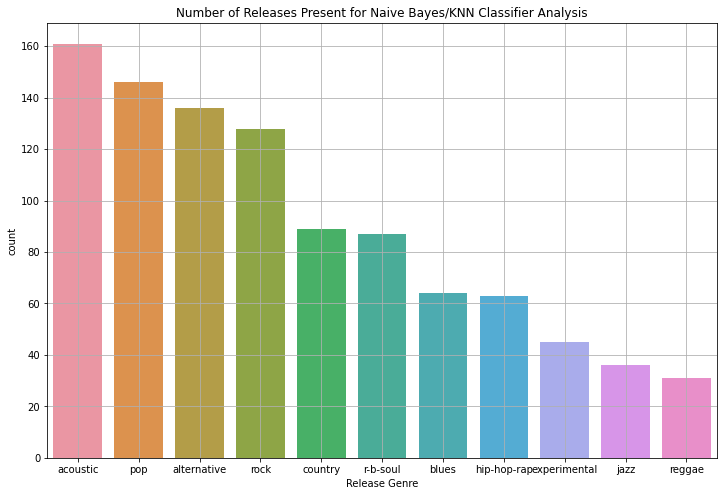

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '10'

fig, ax = plt.subplots(figsize=(12,8))
#sns.set_theme(style="darkgrid")
#titanic = sns.load_dataset("titanic")
sns.countplot(x="Release Genre", data=bandcamp_df, 
              order = bandcamp_df['Release Genre'].value_counts().index, ax=ax)
plt.grid()
plt.title('Number of Releases Present for Naive Bayes/KNN Classifier Analysis')
plt.show()

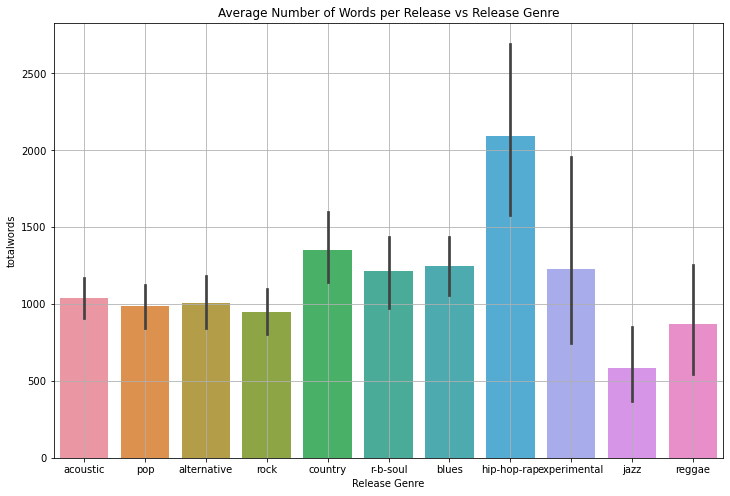

In [7]:
bandcamp_df_totals = bandcamp_df.copy()
bandcamp_df_totals['totalwords'] = bandcamp_df_totals['All Lyrics'].str.split().str.len()
bandcamp_df_totals.head()

# bar chart for month versus count
fig, ax = plt.subplots(figsize=(12,8)) 
sns.barplot(x='Release Genre', y='totalwords', data=bandcamp_df_totals,
            order = bandcamp_df_totals['Release Genre'].value_counts().index, ax=ax)
plt.grid() 
plt.title('Average Number of Words per Release vs Release Genre')
plt.show()


In [8]:
# Cleaning lyrics

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

sw = set(stopwords.words("english"))

def clean(text, stopwords=sw):
    # remove tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # split text on whitespace
    text_list = text.split()
    text_words = []

    punctuation = set(string.punctuation)

    # keep #tags and @mentions
    ## punctuation.remove("#")
    ## punctuation.remove("@")

    for word in text_list:
         # remove punctuation marks at the beginning
         # of each word
        while len(word) > 0 and word[0] in punctuation:
            word = word[1:]

        # remove punctuation marks at the end of each word
        while len(word) > 0 and word[-1] in punctuation:
            word = word[:-1]

        # a rule to eliminate most urls
        if len(word) > 0 and "/" not in word:
            # eliminate stopwords
            if word.lower() not in stopwords:
                # append the word to the text_words list
                text_words.append(word.lower())
        cleaner_text = " ".join(text_words)
    return cleaner_text

def remove_hashtags_mentions_urls(text):
    clean_text = re.sub("@[A-Za-z0-9_]+",'', text)
    clean_text = re.sub("#[A-Za-z0-9_]+",'', clean_text)
    clean_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', clean_text)
    return clean_text

bandcamp_df['All Lyrics'] = bandcamp_df['All Lyrics'].apply(remove_hashtags_mentions_urls)
bandcamp_df['All Lyrics'] = bandcamp_df['All Lyrics'].apply(clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
bandcamp_df.head()

,Release Genre,All Lyrics
595,rock,old man staring outwards fills thoughts contem...
600,rock,see mess including access cold wind dark years...
606,rock,black clouds sky think see another storm horiz...
610,rock,turn head stars find i’m bound pyre feels like...
615,rock,beyond sent morning hunt outward sight sent mo...


# Part 2: Naive Bayes Model Fitting

In [10]:
# Vectorize the corpus of our lyrics data

from sklearn.feature_extraction.text import TfidfVectorizer

corpus = bandcamp_df['All Lyrics'].values
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df=10, 
                             max_features=None,
                             use_idf=True)
X = vectorizer.fit_transform(corpus)


In [11]:
# Split data into train/test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bandcamp_df['All Lyrics'],
                                                    bandcamp_df['Release Genre'].values,
                                                    test_size=0.4)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(591,) (591,)
(395,) (395,)


In [12]:
X_train_vect = vectorizer.transform(X_train)
X_train_vect = X_train_vect.toarray()

X_test = vectorizer.transform(X_test)
X_test = X_test.toarray()

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf = clf.fit(X_train_vect, y_train)

# make prediction on training set
#clf.predict(X_train)

In [13]:
# compute accuracy on training set
print('MulinomialNB Accuracy on Training Set:')
print(clf.score(X_train_vect, y_train))

# compute accuracy on test set
print('MultinomialNB Accuracy on Test Set:')
print(clf.score(X_test, y_test))

MulinomialNB Accuracy on Training Set:
0.5668358714043993
MultinomialNB Accuracy on Test Set:
0.20759493670886076


In [14]:
scores = cross_val_score(estimator=MultinomialNB(), X=X_train_vect, y=y_train, cv=5)
print("Average cross validation score: ", scores.mean())
print("Standard deviation of cross validation scores: ", scores.std())

Average cross validation score:  0.19628258082894176
Standard deviation of cross validation scores:  0.006462047310003042


The Naive Bayes model to try and predict all genres given our lyrical corpus is not very accurate overall, given our cross-validated score of .19. There appears to be a good amount of overfitting occurring. Let's test our model with fewer variables.

In [15]:
# Making Naive Bayes Model for predicting only country/hip-hop-rap songs

bandcamp_df_reduced = bandcamp_df.loc[bandcamp_df['Release Genre'].isin(['country','hip-hop-rap'])]
bandcamp_df_reduced.head()

,Release Genre,All Lyrics
1595,hip-hop-rap,west coast homeboy sandman shelter heat seek m...
1598,hip-hop-rap,fost casa la un dilar care sa pishat pa mine n...
1607,hip-hop-rap,got new flavor coffee got old flavor rap equip...
1611,hip-hop-rap,song response racism prejudice marginalized gr...
1613,hip-hop-rap,yea know march 2nd cursed never felt body hurt...


In [16]:
corpus = bandcamp_df_reduced['All Lyrics'].values
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df=10, 
                             max_features=None,
                             use_idf=True)
X = vectorizer.fit_transform(corpus)

X_train, X_test, y_train, y_test = train_test_split(bandcamp_df_reduced['All Lyrics'],
                                                    bandcamp_df_reduced['Release Genre'].values,
                                                    test_size=0.4)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train_vect = vectorizer.transform(X_train)
X_train_vect = X_train_vect.toarray()

X_test = vectorizer.transform(X_test)
X_test = X_test.toarray()

clf = MultinomialNB()
clf = clf.fit(X_train_vect, y_train)

# compute accuracy on training set
print('MulinomialNB Accuracy on Training Set:')
print(clf.score(X_train_vect, y_train))

# compute accuracy on test set
print('MultinomialNB Accuracy on Test Set:')
print(clf.score(X_test, y_test))

scores = cross_val_score(estimator=MultinomialNB(), X=X_train_vect, y=y_train, cv=5)
print("Average cross validation score: ", scores.mean())
print("Standard deviation of cross validation scores: ", scores.std())

(91,) (91,)
(61,) (61,)
MulinomialNB Accuracy on Training Set:
0.8681318681318682
MultinomialNB Accuracy on Test Set:
0.6721311475409836
Average cross validation score:  0.736842105263158
Standard deviation of cross validation scores:  0.05044177462654463


The Naive Bayes model appears to be much better for predicting two genres, for example country vs. hip-hop/rap, with a cross-validation score of .78. There still appears to be some overfitting occurring however. Let's see if we can make our model more accurate using hyperparameter tuning.

In [17]:
# Naive Bayes Model Fine-Tuning

pipe = Pipeline([('vectorizer',TfidfVectorizer(stop_words='english',
                                             use_idf=True)),
                ('nb',MultinomialNB())])

param_grid = [{'vectorizer__ngram_range':[(1,1),(1,2),(1,3),(1,5),(1,7)],
               'vectorizer__min_df':range(5,20)}]

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5)

grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid=[{'vectorizer__min_df': range(5, 20),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                      (1, 5), (1, 7)]}])

In [18]:
grid.best_params_

{'vectorizer__min_df': 16, 'vectorizer__ngram_range': (1, 1)}

In [19]:
vectorizer = grid.best_estimator_.named_steps['vectorizer']
nb = grid.best_estimator_.named_steps['nb']
vectorizer.fit_transform(corpus)
nb = nb.fit(X_train_vect, y_train)

Our Naive Bayes model did not improve with hyperparameter tuning.

## KNN Text Classification

In [20]:
import numpy
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# Instantiate the KNN Classifier

knn_nlp = KNeighborsClassifier()
knn_nlp.fit(X_train_vect, y_train)

# compute accuracy on training set
print('KNN Accuracy on Training Set:')
print(knn_nlp.score(X_train_vect, y_train))

# compute accuracy on test set
print('KNN Accuracy on Test Set:')
print(knn_nlp.score(X_test, y_test))

scores = cross_val_score(estimator=KNeighborsClassifier(), X=X_train_vect, y=y_train, cv=5)
print("Average cross validation score: ", scores.mean())
print("Standard deviation of cross validation scores: ", scores.std())

KNN Accuracy on Training Set:
0.8791208791208791
KNN Accuracy on Test Set:
0.7704918032786885
Average cross validation score:  0.8146198830409357
Standard deviation of cross validation scores:  0.11010004746019401


The KNN method appears to be more accurate that Naive Bayes at first glance. However, there seems to be some overfitting based on a quick comparison of the accuracy scores.

In [22]:
# Model Fine-Tuning

pipe = Pipeline([('vectorizer',TfidfVectorizer(stop_words='english',
                                             use_idf=True)),
                ('knn', KNeighborsClassifier())])

param_grid = [{'vectorizer__ngram_range':[(1,1),(1,2),(1,3),(1,5),(1,7)],
               'vectorizer__min_df':range(5,20), 'knn__n_neighbors': [3, 5, 10]}]

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=8)

grid.fit(X_train,y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': [3, 5, 10],
                          'vectorizer__min_df': range(5, 20),
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                      (1, 5), (1, 7)]}])

In [23]:
grid.best_params_

{'knn__n_neighbors': 5,
 'vectorizer__min_df': 5,
 'vectorizer__ngram_range': (1, 1)}

In [24]:
vectorizer = grid.best_estimator_.named_steps['vectorizer']
knn = grid.best_estimator_.named_steps['knn']
vectorizer.fit_transform(corpus)
knn = knn.fit(X_train_vect, y_train)

print('Training Accuracy:')
print(knn.score(X_train_vect,y_train))
print('Testing Accuracy:')
print(knn.score(X_test,y_test))

Training Accuracy:
0.8791208791208791
Testing Accuracy:
0.7704918032786885
